# Media Mix Modeling: Pre-Processing

In [1]:
### 0. Load Required Packages and Utility Functions
defaultW = getOption("warn") 
options(warn = -1) 
options(scipen = 10000)

suppressPackageStartupMessages({
    library(rstan)
    options(mc.cores = parallel::detectCores())
    rstan_options(auto_write = TRUE)
    Sys.setenv(LOCAL_CPPFLAGS = '-march=native')

    library(brms)
    library(lme4)
    library(here)
    library(tidyverse)
    library(tidybayes)
    library(bayesplot)
    library(lubridate)
    library(zoo)
    library(ggplot2)
    library(scales)
    library(ggthemes)
})

source("Packages/Utility_Functions_MMM.R")

## Preprocessing

In [2]:
#################################################################################
### 1. Pre-Processing                                                         ###
###                                                                           ###
### (1) Make `df_XyZ`: Target/Media/Control Features.                         ###
### (2) Make `df_seasonal`: Sales Seasonalities.                              ###
### (3) Make `df_norm`: Subscribers/Non-Subscribers by DMA.                   ###
### (4) Create Inputs to `preprocess_MMM`.                                    ###
### (5) Conduct `proprocess_MMM`.                                             ###
###                                                                           ###
#################################################################################

In [3]:
source('Packages/common_functions_mmm.R')

## Read the data in

In [4]:
df_XyZ <- read.csv("Data/mmm_b2c_acq_opt_sdl_Jan18_Sep21_20220407.csv", stringsAsFactor = FALSE)
df_norm <- read.csv("Data/non_sub_data.csv", stringsAsFactor = FALSE)
df_seasonal_opt <- read.csv("Data/ALTICE_OPT_GROSS_ADD_201603_202109_v2.csv", stringsAsFactor = FALSE)
df_seasonal_sdl <- read.csv("Data/ALTICE_SDL_GROSS_ADD_201701_202109_v2.csv", stringsAsFactor = FALSE)

In [5]:
college_dmas <- c('WACO-TEMPLE-BRYAN TX','LUBBOCK TX','GREENVILLE-NEW BERN-WASH NC','OKLAHOMA CITY OK',
                  'JONESBORO AR','TYLER-LONGVIEW TX','LITTLE ROCK AR','SAN ANGELO TX','AMARILLO TX','EUREKA CA',
                  'LAKE CHARLES LA','ODESSA-MIDLAND TX','ABILENE-SWEETWATER TX','PHOENIX AZ','HOUSTON TX','MONROE-EL DORADO LA-AR',
                  'SHREVEPORT LA') 

## Imputations
* Impute the GA from 09/01/2019 and the search variables missing in few DMAs
* In the new refresh period, the google dashboard is providing truncated data. Excluding the truncated period and imputing the missing data

In [6]:
##Renaming the dma column
df_XyZ <- df_XyZ %>%
          dplyr::rename('dma' = 'mmm_b2c_acq_dma')

In [7]:
##Number of periods in a quarter
nbr_period_q = 13

In [8]:
df_XyZ <- get_quarters(df_XyZ)

`summarise()` regrouping output by 'dma' (override with `.groups` argument)



In [9]:
df_XyZ <- df_XyZ %>%
          dplyr::mutate(period = as.Date(period),
                         brand = ifelse(dma == 'NEW YORK, NY','Optimum','Suddenlink'))

`summarise()` regrouping output by 'period' (override with `.groups` argument)



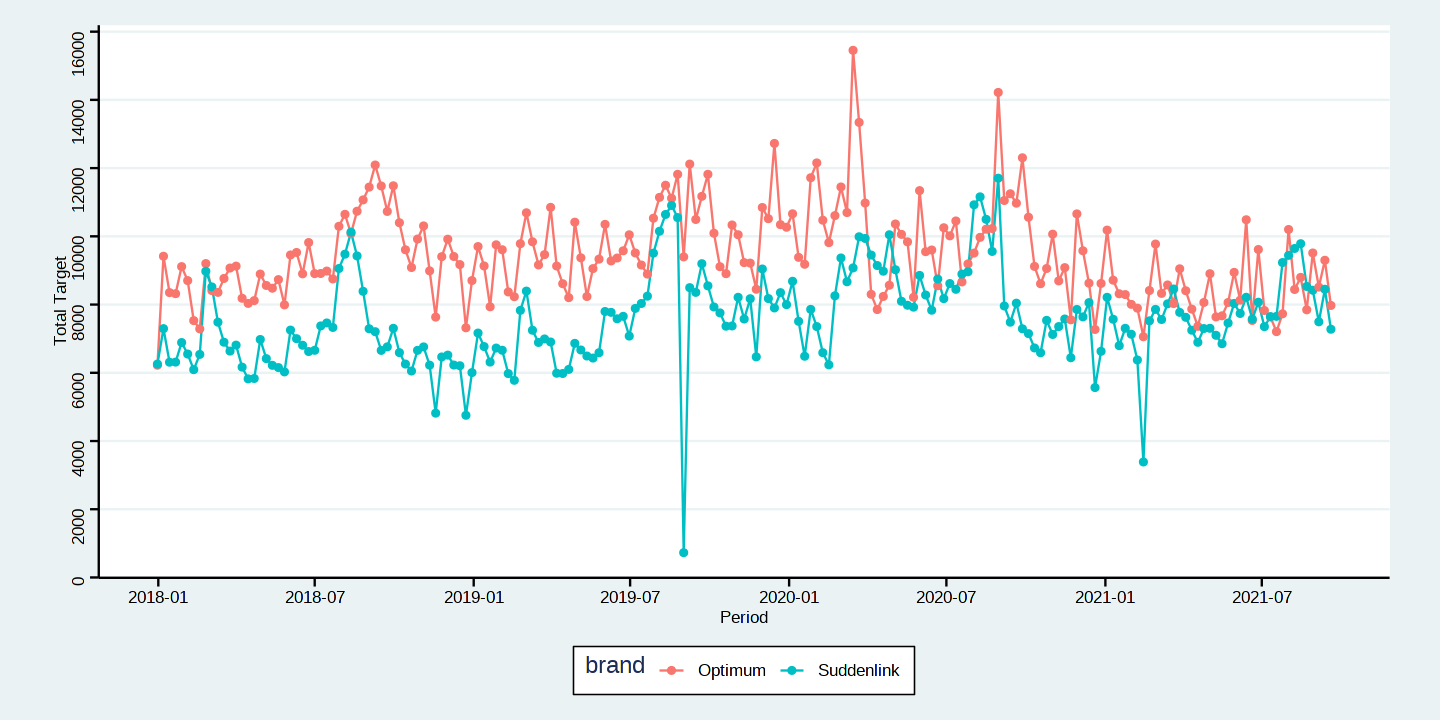

In [10]:
##GA plot before imputation
options(repr.plot.width=12, repr.plot.height = 6) 
df_XyZ %>%
group_by(period,brand) %>%
summarize(total_target = sum(gross_add_true)) %>%
ggplot(.,aes(x = period, y = total_target, group = brand, color = brand))+
geom_line() +
geom_point() +
labs(x = Caps('period'),y = Caps('total_target')) +
scale_x_date(breaks = breaks_pretty(10)) +
scale_y_continuous(breaks = breaks_pretty(7)) +
theme_stata()

In [11]:
##GA imputation
##Compute the mean GA for Q3 2019 and use that as a replacement to the low GA in the week of 01/09/2019
df_XyZ_mean_ga <- df_XyZ %>%
                  dplyr::group_by(dma,qy) %>%
                  summarize(mean_ga = mean(gross_add_true))
df_XyZ_mean_ga

`summarise()` regrouping output by 'dma' (override with `.groups` argument)



dma,qy,mean_ga
<chr>,<chr>,<dbl>
ABILENE-SWEETWATER TX,Q1_2018,206.0769
ABILENE-SWEETWATER TX,Q1_2019,215.6154
ABILENE-SWEETWATER TX,Q1_2020,239.3846
ABILENE-SWEETWATER TX,Q1_2021,217.3846
ABILENE-SWEETWATER TX,Q2_2018,188.8462
ABILENE-SWEETWATER TX,Q2_2019,212.3077
ABILENE-SWEETWATER TX,Q2_2020,276.1538
ABILENE-SWEETWATER TX,Q2_2021,242.3846
ABILENE-SWEETWATER TX,Q3_2018,233.6154


In [12]:
##Join the mean GA df to the main dataframe
df_XyZ1 <- df_XyZ %>%
          dplyr::left_join(df_XyZ_mean_ga,by = c('dma','qy'))

In [13]:
##For the problematic week, replace the GA value
df_XyZ1[df_XyZ1['period']=='2019-09-01',] <- df_XyZ1 %>%
          dplyr::filter(period == '2019-09-01') %>%
          dplyr::mutate(gross_add_true = round(mean_ga))

In [14]:
df_XyZ1 %>%
dplyr::filter(period == '2019-09-01')

period,dma,gross_add_true,gross_add_tot,dm_volume,dm_spend,audio_spend,video_spend,display_spend,paid_search_spend_brand,⋯,covid_cum_deaths,covid_daily_confirmed_cases,covid_daily_deaths,home_pass,hurricane_search,year,quarter,qy,brand,mean_ga
<date>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
2019-09-01,ABILENE-SWEETWATER TX,251,22,15735.434,4158.262,0,499,1893,1857.15,⋯,0,0,0,85237,32.50000,2019,Q3,Q3_2019,Suddenlink,250.92308
2019-09-01,ALEXANDRIA LA,189,16,15769.956,4167.385,0,330,740,2477.79,⋯,0,0,0,85424,22.50000,2019,Q3,Q3_2019,Suddenlink,188.53846
2019-09-01,All Other Suddenlink DMA Total,550,23,59730.848,15784.537,1573,7096,19412,6777.46,⋯,0,0,0,323555,67.10417,2019,Q3,Q3_2019,Suddenlink,549.61538
2019-09-01,AMARILLO TX,350,55,26824.099,7088.565,0,705,1192,2547.94,⋯,0,0,0,145303,48.50000,2019,Q3,Q3_2019,Suddenlink,350.46154
2019-09-01,AUSTIN TX,306,22,15912.842,4205.144,0,1561,2224,1613.49,⋯,0,0,0,86198,32.50000,2019,Q3,Q3_2019,Suddenlink,305.61538
2019-09-01,BLUEFIELD-BECKLEY-OAK HILL WV,183,10,15905.827,4203.291,0,530,1310,3278.41,⋯,0,0,0,86160,41.50000,2019,Q3,Q3_2019,Suddenlink,183.07692
2019-09-01,CHARLESTON-HUNTINGTON WV,403,38,39140.223,10343.236,0,1713,3645,6778.84,⋯,0,0,0,212018,51.66667,2019,Q3,Q3_2019,Suddenlink,402.69231
2019-09-01,DALLAS-FT WORTH TX,492,17,34484.224,9112.837,4,4640,7498,4000.51,⋯,0,0,0,186797,32.50000,2019,Q3,Q3_2019,Suddenlink,492.15385
2019-09-01,EUREKA CA,159,6,10304.820,2723.162,0,360,886,1443.35,⋯,0,0,0,55820,78.50000,2019,Q3,Q3_2019,Suddenlink,158.84615


`summarise()` regrouping output by 'period' (override with `.groups` argument)



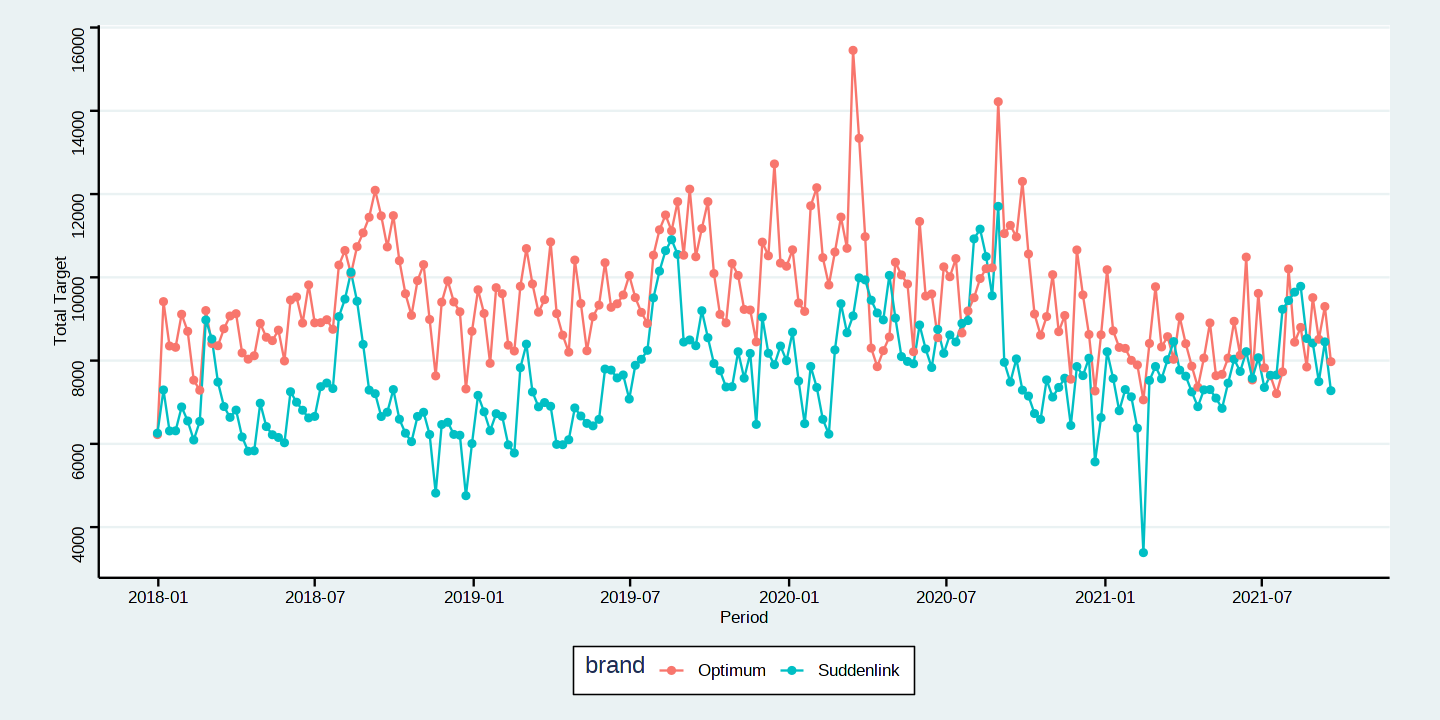

In [15]:
##GA plot after imputation
options(repr.plot.width=12, repr.plot.height = 6) 
df_XyZ1 %>%
group_by(period,brand) %>%
summarize(total_target = sum(gross_add_true)) %>%
ggplot(.,aes(x = period, y = total_target, group = brand, color = brand))+
geom_line() +
geom_point() +
labs(x = Caps('period'),y = Caps('total_target')) +
scale_x_date(breaks = breaks_pretty(10)) +
scale_y_continuous(breaks = breaks_pretty(7)) +
theme_stata()

In [16]:
no_weeks = 4 # Number of weeks for imputation
tg_chr_weeks = c("2018-11-18","2018-12-23",
                 "2019-11-24","2019-12-22",
                 "2020-11-22","2020-12-20")

ts_anom_opt_weeks = c('2018-09-09','2019-12-15',"2020-09-27")

##Adding flags for:
##1. North American winter storm - Suddenlink - Feb 14th 2021
##2. Price for Life offered in Aug 2019
##3. Summer promotion in Suddenlink from July 6th to August 31st 2020
##4. LA DMAs- Hurricane Laura - Post Aug 30th recovery efforts
##3. Semester starting in Aug in some primary university towns (list from business)

df_XyZ2 <- df_XyZ %>% 
  dplyr::mutate(brand  = ifelse(dma == "NEW YORK, NY", "Optimum", "Suddenlink"),
                period = lubridate::as_date(period)) %>% 
  dplyr::select(brand, dma, period, everything()) %>% 
  dplyr::arrange(brand, dma, period) %>% 
  dplyr::as_tibble() %>% 
  dplyr::  mutate(gross_add_tot  = ifelse(period!="2019-09-01", gross_add_tot,
                                          lag(rollapply(gross_add_tot, no_weeks, mean, align = 'right', fill = NA))),
                  gross_add_true = ifelse(period!="2019-09-01", gross_add_true,
                                          lag(rollapply(gross_add_true, no_weeks, mean, align = 'right', fill = NA))),
                  price_for_life = ifelse(period >= "2019-08-05" & period <= "2019-09-29", 1, 0),
                  summer_promotion = ifelse(period >= "2020-07-06" & period <= "2020-08-31",1, 0),
                  winter_storm = ifelse(period == '2021-02-14' & brand == 'Suddenlink',1,0),
                  post_laura = ifelse((period >= "2020-08-30" & period <= "2020-09-30") & (grepl('LA$',dma)==TRUE),1,0),
                  covid_emergency = ifelse(period >="2020-03-13" & period <= "2020-03-23",1,0),
                  enrollment_season = ifelse((month(period) == 8) & (dma%in%college_dmas),1,0),
                 anom_opt = ifelse((dma == 'NEW YORK, NY') & period %in% sapply(ts_anom_opt_weeks,as.Date,USE.NAMES = F),1,0), ##Adding a dummy for OPT anamolies
                 summer_promo_end = ifelse(period == '2020-08-30',1,0),
                 tg_chr_dips = ifelse(period %in% sapply(tg_chr_weeks,as.Date,USE.NAMES = F),1,0),
                 price_hybrid = ifelse(dma == 'NEW YORK, NY', sp_price,dp_price))  

In [17]:
df_XyZ2 %>%distinct(anom_opt)

anom_opt
<dbl>
0
1


In [18]:
df_XyZ2 %>%distinct(summer_promotion)

summer_promotion
<dbl>
0
1


`summarise()` regrouping output by 'period' (override with `.groups` argument)



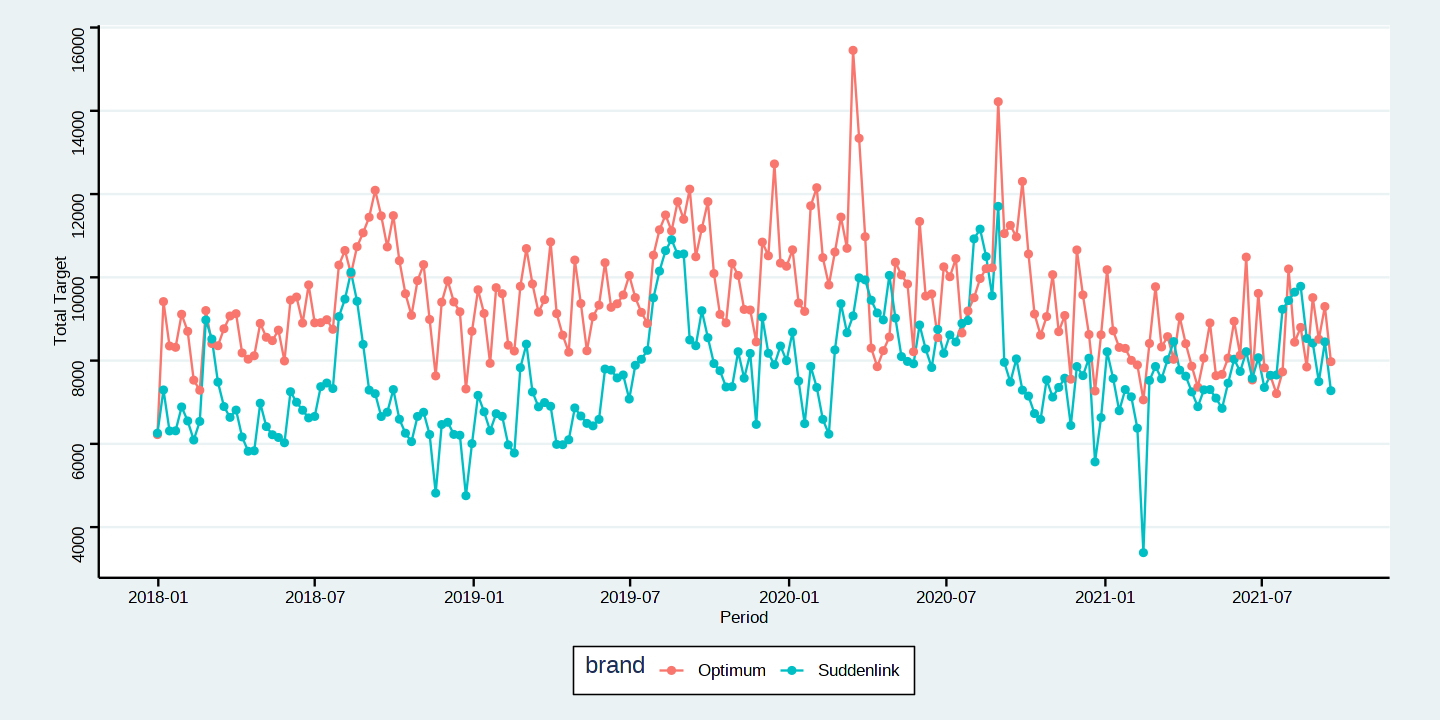

In [19]:
##GA plot after imputation
options(repr.plot.width=12, repr.plot.height = 6) 
df_XyZ2 %>%
group_by(period,brand) %>%
summarize(total_target = sum(gross_add_true)) %>%
ggplot(.,aes(x = period, y = total_target, group = brand, color = brand))+
geom_line() +
geom_point() +
labs(x = Caps('period'),y = Caps('total_target')) +
scale_x_date(breaks = breaks_pretty(10)) +
scale_y_continuous(breaks = breaks_pretty(7)) +
theme_stata()

In [20]:
##Difference
df_XyZ1 %>%
            left_join(df_XyZ2,by = c('dma','period'),suffix = c('','_rolling')) %>%
            filter(period == '2019-09-01') %>%
            group_by(dma) %>%
            summarize(diff_ga = gross_add_true_rolling-gross_add_true,
                      diff_perc = percent(diff_ga/gross_add_true))

`summarise()` ungrouping output (override with `.groups` argument)



dma,diff_ga,diff_perc
<chr>,<dbl>,<chr>
ABILENE-SWEETWATER TX,70.50,28%
ALEXANDRIA LA,31.50,17%
All Other Suddenlink DMA Total,127.75,23%
AMARILLO TX,87.50,25%
AUSTIN TX,34.25,11%
BLUEFIELD-BECKLEY-OAK HILL WV,17.50,10%
CHARLESTON-HUNTINGTON WV,75.25,19%
DALLAS-FT WORTH TX,75.00,15%
EUREKA CA,73.75,46%


### Impute the seasonal data as well

In [21]:
df_seasonal_sdl <- df_seasonal_sdl %>%
                   dplyr::rename('dma' = 'mmm_b2c_acq_dma') %>%
                   dplyr::filter(dma != 'OTHER')

In [22]:
df_XyZ <- df_XyZ2 %>%
          dplyr::arrange(dma,period)

In [23]:
df_seasonal_opt <- df_seasonal_opt %>%
                   dplyr::mutate(dma = 'NEW YORK, NY')
df_seasonal <- df_seasonal_opt %>% 
  dplyr::bind_rows(df_seasonal_sdl) %>% 
  dplyr::arrange(dma, period) %>%
  dplyr::mutate(brand = ifelse(dma == 'NEW YORK, NY','Optimum','Suddenlink'),
               period = lubridate::as_date(period)) %>%
  dplyr::select(brand, dma, period, everything()) %>% 
  dplyr::  mutate(gross_add_tot  = ifelse(period!="2019-09-01", gross_add_tot,
                                          lag(rollapply(gross_add_tot, no_weeks, mean, align = 'right', fill = NA))),
                  gross_add_true = ifelse(period!="2019-09-01", gross_add_true,
                                          lag(rollapply(gross_add_true, no_weeks, mean, align = 'right', fill = NA))))

## Check whether dma names are identical.
dma_XyZ      = df_XyZ %>% select(dma) %>% distinct(dma) %>% arrange(dma) %>% pull()
dma_seasonal = df_seasonal %>% select(dma) %>% distinct(dma) %>% arrange(dma) %>% pull()
identical(dma_XyZ, dma_seasonal)


[1] TRUE

### Search data imputation

In [24]:
##Drop the additional columns like qy,year and quarter
df_XyZ <- df_XyZ %>%
          dplyr::select(-qy,-quarter,-year)

In [25]:
##Get the DMAs for which the search data is missing
missing_dmas <- df_XyZ %>%
                dplyr::filter(google_altice_search_idx == 0 & period >= '2018-02-04') %>%
                dplyr::select(dma) %>%
                dplyr::distinct() %>%
                dplyr::pull()

missing_dmas

[1] "JONESBORO AR"   "PARKERSBURG WV" "SAN ANGELO TX"  "ST JOSEPH MO"  
[5] "VICTORIA TX"

In [26]:
##Extract the search data for SDL
df_search_dma = df_XyZ %>%
                dplyr::filter(!(dma=='NEW YORK, NY'))%>%
                dplyr::select(period,dma,matches('google_*')) %>%
                dplyr::group_by(period) %>%
                mutate(total_comp = sum(google_comp_search_idx),
                       total_comp_brand = sum(google_altice_search_idx),
                       total_comp_nb = sum(google_non_brand_search_idx)) %>%
                filter(dma%in%missing_dmas) %>%
                select(period,dma,matches('total')) %>%
                group_by(dma,period) %>%
                tidyr::gather(key = 'search',value = 'value',-dma,-period)

df_search_dma

period,dma,search,value
<date>,<chr>,<chr>,<dbl>
2017-12-31,JONESBORO AR,total_comp,0
2018-01-07,JONESBORO AR,total_comp,0
2018-01-14,JONESBORO AR,total_comp,0
2018-01-21,JONESBORO AR,total_comp,0
2018-01-28,JONESBORO AR,total_comp,0
2018-02-04,JONESBORO AR,total_comp,8676133
2018-02-11,JONESBORO AR,total_comp,8295643
2018-02-18,JONESBORO AR,total_comp,8782752
2018-02-25,JONESBORO AR,total_comp,9549037


In [27]:
##Calculate the percentage of GA these DMAs contribute 
dma_ga_df <- df_XyZ %>%
            dplyr::filter(!(dma=='NEW YORK, NY')) %>%
            dplyr::group_by(period) %>%
            mutate(total_sdl_ga = sum(gross_add_true)) %>%
            dplyr::group_by(period,dma) %>%
            dplyr::summarize(total_dma_ga = sum(gross_add_true),
                             total_sdl_ga = total_sdl_ga,
                             perc_ga = total_dma_ga/total_sdl_ga) %>%
            dplyr::filter(dma%in%missing_dmas) %>%
            distinct()

dma_ga_df

`summarise()` regrouping output by 'period' (override with `.groups` argument)



period,dma,total_dma_ga,total_sdl_ga,perc_ga
<date>,<chr>,<dbl>,<dbl>,<dbl>
2017-12-31,JONESBORO AR,100,6256,0.01598465
2017-12-31,PARKERSBURG WV,129,6256,0.02062020
2017-12-31,SAN ANGELO TX,119,6256,0.01902174
2017-12-31,ST JOSEPH MO,76,6256,0.01214834
2017-12-31,VICTORIA TX,72,6256,0.01150895
2018-01-07,JONESBORO AR,105,7295,0.01439342
2018-01-07,PARKERSBURG WV,101,7295,0.01384510
2018-01-07,SAN ANGELO TX,189,7295,0.02590816
2018-01-07,ST JOSEPH MO,94,7295,0.01288554


In [28]:
##Join the two dfs and compute the search data for the missing DMAs as the share of GA times the total SDL search index
search_imp_df <- df_search_dma %>%
                dplyr::left_join(dma_ga_df, by = c('period','dma')) %>%
                select(period,dma,search,value,perc_ga) %>%
                mutate(search_vol_dma = value*perc_ga) %>%
                select(-value,-perc_ga) %>%
                group_by(period,dma) %>%
                spread(key = 'search', value = 'search_vol_dma') %>%
                rename('google_comp_search_idx' = 'total_comp',
                       'google_altice_search_idx' = 'total_comp_brand',
                       'google_non_brand_search_idx' = 'total_comp_nb')

search_imp_df

period,dma,google_comp_search_idx,google_altice_search_idx,google_non_brand_search_idx
<date>,<chr>,<dbl>,<dbl>,<dbl>
2017-12-31,JONESBORO AR,0.0,0.000,0.00
2017-12-31,PARKERSBURG WV,0.0,0.000,0.00
2017-12-31,SAN ANGELO TX,0.0,0.000,0.00
2017-12-31,ST JOSEPH MO,0.0,0.000,0.00
2017-12-31,VICTORIA TX,0.0,0.000,0.00
2018-01-07,JONESBORO AR,0.0,0.000,0.00
2018-01-07,PARKERSBURG WV,0.0,0.000,0.00
2018-01-07,SAN ANGELO TX,0.0,0.000,0.00
2018-01-07,ST JOSEPH MO,0.0,0.000,0.00


In [29]:
##Replace the values in the original df with the imputed ones
df_XyZ1 <- df_XyZ %>%
            dplyr::left_join(search_imp_df, by = c('period','dma'),suffix = c('','_imp')) %>%
            dplyr::mutate(google_comp_search_idx = ifelse(is.na(google_comp_search_idx_imp),google_comp_search_idx,google_comp_search_idx_imp),
                         google_altice_search_idx = ifelse(is.na(google_altice_search_idx_imp),google_altice_search_idx,google_altice_search_idx_imp),
                         google_non_brand_search_idx = ifelse(is.na(google_non_brand_search_idx_imp),google_non_brand_search_idx,google_non_brand_search_idx_imp)) %>%
            dplyr::select(-matches('*_imp'))

df_XyZ1

brand,dma,period,gross_add_true,gross_add_tot,dm_volume,dm_spend,audio_spend,video_spend,display_spend,⋯,price_for_life,summer_promotion,winter_storm,post_laura,covid_emergency,enrollment_season,anom_opt,summer_promo_end,tg_chr_dips,price_hybrid
<chr>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Suddenlink,ABILENE-SWEETWATER TX,2017-12-31,212,285,26044.42,7079.970,0.00,249.33,1187.00,⋯,0,0,0,0,0,0,0,0,0,69.99
Suddenlink,ABILENE-SWEETWATER TX,2018-01-07,235,294,19237.14,5466.984,0.00,199.27,1193.94,⋯,0,0,0,0,0,0,0,0,0,69.99
Suddenlink,ABILENE-SWEETWATER TX,2018-01-14,188,249,19212.19,5355.782,0.00,199.62,2237.93,⋯,0,0,0,0,0,0,0,0,0,69.99
Suddenlink,ABILENE-SWEETWATER TX,2018-01-21,180,235,17909.49,5041.937,0.00,187.03,2454.55,⋯,0,0,0,0,0,0,0,0,0,69.99
Suddenlink,ABILENE-SWEETWATER TX,2018-01-28,201,290,18070.56,5316.287,0.00,222.08,3014.34,⋯,0,0,0,0,0,0,0,0,0,69.99
Suddenlink,ABILENE-SWEETWATER TX,2018-02-04,181,255,18011.60,5859.819,0.00,246.23,2820.38,⋯,0,0,0,0,0,0,0,0,0,69.99
Suddenlink,ABILENE-SWEETWATER TX,2018-02-11,171,253,15642.09,4209.766,0.00,241.35,2709.71,⋯,0,0,0,0,0,0,0,0,0,69.99
Suddenlink,ABILENE-SWEETWATER TX,2018-02-18,176,246,17936.13,5230.298,0.00,921.29,2872.46,⋯,0,0,0,0,0,0,0,0,0,69.99
Suddenlink,ABILENE-SWEETWATER TX,2018-02-25,288,386,17732.23,4654.164,0.00,107.03,3118.46,⋯,0,0,0,0,0,0,0,0,0,69.99


In [30]:
df_XyZ1 %>%
select(period,dma,matches('google*'))

period,dma,google_altice_search_idx,google_comp_search_idx,google_non_brand_search_idx
<date>,<chr>,<dbl>,<dbl>,<dbl>
2017-12-31,ABILENE-SWEETWATER TX,0.00,0.00,0.00
2018-01-07,ABILENE-SWEETWATER TX,0.00,0.00,0.00
2018-01-14,ABILENE-SWEETWATER TX,0.00,0.00,0.00
2018-01-21,ABILENE-SWEETWATER TX,0.00,0.00,0.00
2018-01-28,ABILENE-SWEETWATER TX,0.00,0.00,0.00
2018-02-04,ABILENE-SWEETWATER TX,16868.11,9482.16,10708.11
2018-02-11,ABILENE-SWEETWATER TX,17170.81,9141.62,9996.76
2018-02-18,ABILENE-SWEETWATER TX,17965.41,10344.86,13757.84
2018-02-25,ABILENE-SWEETWATER TX,18820.54,10163.24,12970.81


In [31]:
##Get the DMAs for which the search data is missing - Post imputation
missing_dmas <- df_XyZ1 %>%
                dplyr::filter(google_altice_search_idx == 0 & period >= '2018-02-04') %>%
                dplyr::select(dma) %>%
                dplyr::distinct() %>%
                dplyr::pull()

missing_dmas

character(0)

### Additional price data

In [32]:
df_XyZ1 <- df_XyZ1 %>%
           dplyr::rename_at(.vars = vars(-period,-dma),.funs = ~gsub('bill_per_hh',replacement = 'price',.))

glimpse(df_XyZ1)

Rows: 5,850
Columns: 78
$ brand                       <chr> "Suddenlink", "Suddenlink", "Suddenlink",…
$ dma                         <chr> "ABILENE-SWEETWATER TX", "ABILENE-SWEETWA…
$ period                      <date> 2017-12-31, 2018-01-07, 2018-01-14, 2018…
$ gross_add_true              <dbl> 212, 235, 188, 180, 201, 181, 171, 176, 2…
$ gross_add_tot               <dbl> 285, 294, 249, 235, 290, 255, 253, 246, 3…
$ dm_volume                   <dbl> 26044.42, 19237.14, 19212.19, 17909.49, 1…
$ dm_spend                    <dbl> 7079.970, 5466.984, 5355.782, 5041.937, 5…
$ audio_spend                 <dbl> 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,…
$ video_spend                 <dbl> 249.33, 199.27, 199.62, 187.03, 222.08, 2…
$ display_spend               <dbl> 1187.00, 1193.94, 2237.93, 2454.55, 3014.…
$ paid_search_spend_brand     <dbl> 636.31, 1080.04, 1084.88, 1070.57, 1069.9…
$ paid_search_spend_unbranded <dbl> 1110.56, 1878.54, 865.93, 417.30, 549.37,…
$ paid_search_spend         

In [33]:
##Get the price variables at the footprint level
arpu_data_fprint <- df_XyZ1 %>%
                    select(period,dma,brand,matches('avg_.*_price'),hh_cnt) %>%
                    gather(key = metric,value = amount, -dma, - brand, - period, -hh_cnt) %>%
                    group_by(period,dma,brand,metric) %>%
                    summarize(amount = sum(hh_cnt*amount),
                              hh_cnt = sum(hh_cnt)) %>%
                    ungroup() %>%
                    group_by(period,brand,metric) %>%
                    summarize(amount = sum(amount),
                              hh_cnt = sum(hh_cnt)) %>%
                    mutate(amount = amount/hh_cnt) %>%
                    spread(metric,amount) 
arpu_data_fprint

`summarise()` regrouping output by 'period', 'dma', 'brand' (override with `.groups` argument)

`summarise()` regrouping output by 'period', 'brand' (override with `.groups` argument)



period,brand,hh_cnt,avg_ool_price,avg_ov_price,avg_tot_price,avg_video_price
<date>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
2017-12-31,Optimum,7913,48.14000,6.480000,100.98000,46.37000
2017-12-31,Suddenlink,7813,48.00032,2.482277,86.42353,35.94191
2018-01-07,Optimum,11249,48.74000,6.380000,99.94000,44.82000
2018-01-07,Suddenlink,8952,47.60471,2.620555,86.09640,35.87096
2018-01-14,Optimum,9990,49.25000,6.420000,100.87000,45.20000
2018-01-14,Suddenlink,7735,47.73536,2.334131,85.52025,35.45115
2018-01-21,Optimum,9961,49.10000,6.620000,102.87000,47.15000
2018-01-21,Suddenlink,7967,48.15538,2.553585,87.02385,36.31633
2018-01-28,Optimum,11868,49.92000,6.510000,104.08000,47.64000


In [34]:
df_XyZ1 <- df_XyZ1 %>%
            left_join(arpu_data_fprint,by = c('period','brand'),suffix = c('','_fprint')) %>%
            ungroup() %>%
            as.data.frame()

glimpse(df_XyZ1)

Rows: 5,850
Columns: 83
$ brand                       <chr> "Suddenlink", "Suddenlink", "Suddenlink",…
$ dma                         <chr> "ABILENE-SWEETWATER TX", "ABILENE-SWEETWA…
$ period                      <date> 2017-12-31, 2018-01-07, 2018-01-14, 2018…
$ gross_add_true              <dbl> 212, 235, 188, 180, 201, 181, 171, 176, 2…
$ gross_add_tot               <dbl> 285, 294, 249, 235, 290, 255, 253, 246, 3…
$ dm_volume                   <dbl> 26044.42, 19237.14, 19212.19, 17909.49, 1…
$ dm_spend                    <dbl> 7079.970, 5466.984, 5355.782, 5041.937, 5…
$ audio_spend                 <dbl> 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,…
$ video_spend                 <dbl> 249.33, 199.27, 199.62, 187.03, 222.08, 2…
$ display_spend               <dbl> 1187.00, 1193.94, 2237.93, 2454.55, 3014.…
$ paid_search_spend_brand     <dbl> 636.31, 1080.04, 1084.88, 1070.57, 1069.9…
$ paid_search_spend_unbranded <dbl> 1110.56, 1878.54, 865.93, 417.30, 549.37,…
$ paid_search_spend         

In [35]:
df_XyZ1 <- df_XyZ1 %>%
            rename(price_ARPU = avg_tot_price,
                   price_ARPU_fprint = avg_tot_price_fprint)

glimpse(df_XyZ1)

Rows: 5,850
Columns: 83
$ brand                       <chr> "Suddenlink", "Suddenlink", "Suddenlink",…
$ dma                         <chr> "ABILENE-SWEETWATER TX", "ABILENE-SWEETWA…
$ period                      <date> 2017-12-31, 2018-01-07, 2018-01-14, 2018…
$ gross_add_true              <dbl> 212, 235, 188, 180, 201, 181, 171, 176, 2…
$ gross_add_tot               <dbl> 285, 294, 249, 235, 290, 255, 253, 246, 3…
$ dm_volume                   <dbl> 26044.42, 19237.14, 19212.19, 17909.49, 1…
$ dm_spend                    <dbl> 7079.970, 5466.984, 5355.782, 5041.937, 5…
$ audio_spend                 <dbl> 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,…
$ video_spend                 <dbl> 249.33, 199.27, 199.62, 187.03, 222.08, 2…
$ display_spend               <dbl> 1187.00, 1193.94, 2237.93, 2454.55, 3014.…
$ paid_search_spend_brand     <dbl> 636.31, 1080.04, 1084.88, 1070.57, 1069.9…
$ paid_search_spend_unbranded <dbl> 1110.56, 1878.54, 865.93, 417.30, 549.37,…
$ paid_search_spend         

In [36]:
### 4. Inputs to `preprocess_MMM`
# Need Data Dictionary.

data_XyZ        = data.frame(df_XyZ1)
data_seasonal   = df_seasonal
data_norm       = df_norm
target_var      = c('gross_add_true')
media_names     = c('tv_spend', 'dm_spend', 'paid_search_spend_brand', 'paid_search_spend_unbranded', 
                    'display_spend', 'radio_spend', 'video_spend', 'print_spend', 'social_spend', 'audio_spend')
control_names   = c('sp_price', 'dp_price','price_hybrid', 'price_ARPU' , 'price_ARPU_fprint' ,'competition', 
                     'avg_video_price','avg_ov_price','avg_ool_price','avg_video_price_fprint','avg_ool_price_fprint','avg_ov_price_fprint',
                    'competitive_offer', 'equipment_offer', 'financial_offer', 'financial_offer_amount', 
                    'istart_offer', 'premier_video_offer', 'winback_offer', 'tot_offer_cnt',
                    'inflation', 'hurricane_search', 'snow','snwd',
                    'big_holiday', 'end_of_month', 'q4_tag', 'yearend_flag','covid_emergency','tg_chr_dips',
                    'price_for_life','summer_promotion','summer_promo_end','winter_storm','anom_opt','post_laura','enrollment_season', ##Dummies created
                     'google_altice_search_idx','google_comp_search_idx','google_non_brand_search_idx',
                    'covid_daily_confirmed_cases','covid_daily_deaths','covid_cum_confirmed_cases','covid_cum_deaths')
weather_names   = tolower(c('AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'))
compute_PCA     = 'YES'
N_lag_target    = 1 
N_lag_media     = 13
min_var_weather = 1
data_frequency  = 'weekly'
DMA_Infos       = TRUE
subs            = 'no'
X_percentile    = 1
y_percentile = 1
media_norm_var = rep('non_sub',length(media_names))
media_group_norm_var = rep(1,length(media_names))
target_norm_var = 'non_sub'

save(data_XyZ, file = "RData/data_XyZ.RData")



In [37]:
pp_MMM_search = preprocess_MMM(data_XyZ        = data_XyZ,
                               data_seasonal   = data_seasonal,
                               data_norm       = data_norm,
                               target_var      = target_var,
                               media_names     = media_names,
                               control_names   = control_names,
                               weather_names   = weather_names,
                               compute_PCA     = compute_PCA,
                               N_lag_target    = N_lag_target,
                               N_lag_media     = N_lag_media,
                               min_var_weather = min_var_weather,
                               data_frequency  = data_frequency,
                               DMA_Infos       = DMA_Infos,
                               subs            = subs,
                               target_norm_var = target_norm_var,
                               media_norm_var = media_norm_var,
                               media_group_norm_var = media_group_norm_var,
                               X_percentile    = X_percentile,
                               y_percentile = y_percentile)


Note: Preprocessing of MMM Raw Datasets
1. Target, 'y'
 - Normalize 'y' by 'non_sub'.
 - Transform Normalized 'y' by Max('y').
 - Create Lagged 'y'.
 - Create Seasonality.

 - Create Trend.

2. Media Variables, 'X'
 - Normalize 'X' by `Normalization Variable` per Media Channel:

|Media Channel               |Normalization Variable |
|:---------------------------|:----------------------|
|tv_spend                    |non_sub                |
|dm_spend                    |non_sub                |
|paid_search_spend_brand     |non_sub                |
|paid_search_spend_unbranded |non_sub                |
|display_spend               |non_sub                |
|radio_spend                 |non_sub                |
|video_spend                 |non_sub                |
|print_spend                 |non_sub                |
|social_spend                |non_sub                |
|audio_spend                 |non_sub                |

 - Transform Normalized 'X' by MinMax('X').
 - Create Lagg

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma', 'X' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'X' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)




Note: Principal Component Analysis of Weather Variables
1. 4 components are selected by 'min_var_weather'=1.
2. 96.19% of the total variance are explained by the selected components.


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(target_norm_var)` instead of `target_norm_var` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(control_norm_per_capita_var)` instead of `control_norm_per_capita_var` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)




Note: Summary of MMM Raw Datasets
1. 'data_XyZ'
 - Number of X      : 10 Media Variables
 - Number of Z      : 49 Control Variables
 - Study Period     : 2017-12-31 ~ 2021-09-19
 - Number of weeks  : 195 weeks
 - Number of DMAs   : 30 DMAs
2. 'data_seasonal'
 - Optimum
   - Study Period   : 2016-02-28 ~ 2021-09-19
   - Number of weeks : 291 weeks
 - Suddenlink
   - Study Period   : 2017-01-01 ~ 2021-09-19
   - Number of weeks : 247 weeks
3. 'data_norm'
 - Number of DMAs   : 30 DMAs



In [38]:
save(pp_MMM_search,file = 'RData/pp_MMM.RData')

## Preprocessing with TS

In [39]:
##Joining the ARIMA variables to the main data frame
load('RData/df_ARMA.RData')

In [40]:
df_ARMA_B2C

brand,dma,period,AR_1,MA_6
<chr>,<chr>,<date>,<dbl>,<dbl>
Suddenlink,ABILENE-SWEETWATER TX,2017-12-31,177,198.1667
Suddenlink,ABILENE-SWEETWATER TX,2018-01-07,212,198.8333
Suddenlink,ABILENE-SWEETWATER TX,2018-01-14,235,199.5000
Suddenlink,ABILENE-SWEETWATER TX,2018-01-21,188,192.6667
Suddenlink,ABILENE-SWEETWATER TX,2018-01-28,180,182.8333
Suddenlink,ABILENE-SWEETWATER TX,2018-02-04,201,199.5000
Suddenlink,ABILENE-SWEETWATER TX,2018-02-11,181,212.0000
Suddenlink,ABILENE-SWEETWATER TX,2018-02-18,171,213.5000
Suddenlink,ABILENE-SWEETWATER TX,2018-02-25,176,219.6667


In [41]:
data_XyZ_ts = data_XyZ %>%
            dplyr::left_join(df_ARMA_B2C,by = c('period','dma','brand')) %>%
            dplyr::select(-'AR_1')

In [42]:
glimpse(data_XyZ_ts)

Rows: 5,850
Columns: 84
$ brand                       <chr> "Suddenlink", "Suddenlink", "Suddenlink",…
$ dma                         <chr> "ABILENE-SWEETWATER TX", "ABILENE-SWEETWA…
$ period                      <date> 2017-12-31, 2018-01-07, 2018-01-14, 2018…
$ gross_add_true              <dbl> 212, 235, 188, 180, 201, 181, 171, 176, 2…
$ gross_add_tot               <dbl> 285, 294, 249, 235, 290, 255, 253, 246, 3…
$ dm_volume                   <dbl> 26044.42, 19237.14, 19212.19, 17909.49, 1…
$ dm_spend                    <dbl> 7079.970, 5466.984, 5355.782, 5041.937, 5…
$ audio_spend                 <dbl> 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00,…
$ video_spend                 <dbl> 249.33, 199.27, 199.62, 187.03, 222.08, 2…
$ display_spend               <dbl> 1187.00, 1193.94, 2237.93, 2454.55, 3014.…
$ paid_search_spend_brand     <dbl> 636.31, 1080.04, 1084.88, 1070.57, 1069.9…
$ paid_search_spend_unbranded <dbl> 1110.56, 1878.54, 865.93, 417.30, 549.37,…
$ paid_search_spend         

In [43]:
save(data_XyZ_ts,file='RData/data_XyZ_ts.RData')

In [44]:
##Run preprocessing
### 4. Inputs to `preprocess_MMM`
# Need Data Dictionary.
data_XyZ        = data_XyZ_ts
data_seasonal   = df_seasonal
data_norm       = df_norm
target_var      = c('gross_add_true')
media_names     = c('tv_spend', 'dm_spend', 'paid_search_spend_brand', 'paid_search_spend_unbranded', 
                    'display_spend', 'radio_spend', 'video_spend', 'print_spend', 'social_spend', 'audio_spend')
control_names   = c('MA_6','sp_price', 'dp_price', 'price_hybrid', 'price_ARPU', 'price_ARPU_fprint', 'competition', 
                    'avg_video_price','avg_ov_price','avg_ool_price','avg_video_price_fprint','avg_ool_price_fprint','avg_ov_price_fprint',
                    'competitive_offer', 'equipment_offer', 'financial_offer', 'financial_offer_amount', 
                    'istart_offer', 'premier_video_offer', 'winback_offer', 'tot_offer_cnt',
                    'inflation', 'hurricane_search','snow','snwd',
                    'big_holiday', 'end_of_month', 'q4_tag', 'yearend_flag','covid_emergency','tg_chr_dips',
                    'price_for_life','summer_promotion','summer_promo_end','winter_storm','anom_opt','post_laura','enrollment_season', ##Dummies created
                     'google_altice_search_idx','google_comp_search_idx','google_non_brand_search_idx',
                    'covid_daily_confirmed_cases','covid_daily_deaths','covid_cum_confirmed_cases','covid_cum_deaths')
weather_names   = tolower(c('AWND', 'PRCP', 'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5'))
compute_PCA     = 'YES'
N_lag_target    = 1 
N_lag_media     = 13
min_var_weather = 1
data_frequency  = 'weekly'
DMA_Infos       = TRUE
subs            = 'no'
X_percentile    = 1
y_percentile = 1
media_norm_var = rep('non_sub',length(media_names))
media_group_norm_var = rep(1,length(media_names))
target_norm_var = 'non_sub'
control_norm_per_capita_var = c('google_altice_search_idx','google_comp_search_idx','google_non_brand_search_idx','MA_6',
                                 'covid_daily_confirmed_cases','covid_daily_deaths','covid_cum_confirmed_cases','covid_cum_deaths')

pp_MMM_ts = preprocess_MMM(data_XyZ        = data_XyZ,
                               data_seasonal   = data_seasonal,
                               data_norm       = data_norm,
                               target_var      = target_var,
                               media_names     = media_names,
                               control_names   = control_names,
                               weather_names   = weather_names,
                               compute_PCA     = compute_PCA,
                               N_lag_target    = N_lag_target,
                               N_lag_media     = N_lag_media,
                               min_var_weather = min_var_weather,
                               data_frequency  = data_frequency,
                               DMA_Infos       = DMA_Infos,
                               subs            = subs,
                               target_norm_var = target_norm_var,
                               media_norm_var = media_norm_var,
                               media_group_norm_var = media_group_norm_var,
                               X_percentile    = X_percentile,
                               y_percentile = y_percentile,
                               control_norm_per_capita_var = control_norm_per_capita_var)


Note: Preprocessing of MMM Raw Datasets
1. Target, 'y'
 - Normalize 'y' by 'non_sub'.
 - Transform Normalized 'y' by Max('y').
 - Create Lagged 'y'.
 - Create Seasonality.

 - Create Trend.

2. Media Variables, 'X'
 - Normalize 'X' by `Normalization Variable` per Media Channel:

|Media Channel               |Normalization Variable |
|:---------------------------|:----------------------|
|tv_spend                    |non_sub                |
|dm_spend                    |non_sub                |
|paid_search_spend_brand     |non_sub                |
|paid_search_spend_unbranded |non_sub                |
|display_spend               |non_sub                |
|radio_spend                 |non_sub                |
|video_spend                 |non_sub                |
|print_spend                 |non_sub                |
|social_spend                |non_sub                |
|audio_spend                 |non_sub                |

 - Transform Normalized 'X' by MinMax('X').
 - Create Lagg

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma', 'X' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'X' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)




Note: Principal Component Analysis of Weather Variables
1. 4 components are selected by 'min_var_weather'=1.
2. 96.19% of the total variance are explained by the selected components.


`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)




Note: Summary of MMM Raw Datasets
1. 'data_XyZ'
 - Number of X      : 10 Media Variables
 - Number of Z      : 50 Control Variables
 - Study Period     : 2017-12-31 ~ 2021-09-19
 - Number of weeks  : 195 weeks
 - Number of DMAs   : 30 DMAs
2. 'data_seasonal'
 - Optimum
   - Study Period   : 2016-02-28 ~ 2021-09-19
   - Number of weeks : 291 weeks
 - Suddenlink
   - Study Period   : 2017-01-01 ~ 2021-09-19
   - Number of weeks : 247 weeks
3. 'data_norm'
 - Number of DMAs   : 30 DMAs



In [45]:
pp_MMM_ts$control$Z_minmax

dma_id,dma,X,X_min,X_max
<int>,<chr>,<chr>,<dbl>,<dbl>
1,ABILENE-SWEETWATER TX,anom_opt,0.000000000,0.000000000
1,ABILENE-SWEETWATER TX,AR1,100.000000000,401.000000000
1,ABILENE-SWEETWATER TX,avg_ool_price,30.020000000,71.610000000
1,ABILENE-SWEETWATER TX,avg_ool_price_fprint,41.209194186,66.103976919
1,ABILENE-SWEETWATER TX,avg_ov_price,0.450000000,2.850000000
1,ABILENE-SWEETWATER TX,avg_ov_price_fprint,0.764015222,3.368055455
1,ABILENE-SWEETWATER TX,avg_video_price,7.920000000,38.280000000
1,ABILENE-SWEETWATER TX,avg_video_price_fprint,16.254203922,42.180581610
1,ABILENE-SWEETWATER TX,big_holiday,0.000000000,1.000000000


In [46]:
save(pp_MMM_ts,file = 'RData/pp_MMM_ts.RData')

### Explore the target and spending columns for the quantiles cut-off

In [47]:
n_obs = nrow(pp_MMM_ts$media$X_per_capita)
n_obs

[1] 5850

In [48]:
pp_MMM_ts$target$y_per_capita %>%
mutate(max_99 = quantile(gross_add_true,0.99,na.rm = TRUE),
       max_95 = quantile(gross_add_true,0.95,na.rm = TRUE),
        max_995 = quantile(gross_add_true,0.995,na.rm = TRUE),
       flag_g_95 = ifelse(gross_add_true>=max_95,1,0),
       flag_g_99 = ifelse(gross_add_true>=max_99,1,0),
      flag_g_995 = ifelse(gross_add_true>=max_995,1,0),) %>%
summarize(total_obs_95 = sum(flag_g_95),
          total_obs_99 = sum(flag_g_99),
          total_obs_995 = sum(flag_g_995),
          perc_obs_95 = percent(total_obs_95/n_obs),
          perc_obs_99 = percent(total_obs_99/n_obs),
          perc_obs_995 = percent(total_obs_995/n_obs)
         )

total_obs_95,total_obs_99,total_obs_995,perc_obs_95,perc_obs_99,perc_obs_995
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
294,59,30,5%,1%,1%


In [49]:
##Across all media 
pp_MMM_ts$media$X_per_capita %>%
gather(key = X, value = value,-dma_id,-dma,-period) %>%
mutate(max_99 = quantile(value,0.99,na.rm = TRUE),
       max_95 = quantile(value,0.95,na.rm = TRUE),
        max_995 = quantile(value,0.995,na.rm = TRUE),
       flag_g_95 = ifelse(value>=max_95,1,0),
       flag_g_99 = ifelse(value>=max_99,1,0),
       flag_g_995 = ifelse(value>=max_995,1,0)
      ) %>%
summarize(total_obs_95 = sum(flag_g_95),
          total_obs_99 = sum(flag_g_99),
          total_obs_995 = sum(flag_g_995),
          perc_obs_95 = percent(total_obs_95/n_obs),
          perc_obs_99 = percent(total_obs_99/n_obs),
          perc_obs_995 = percent(total_obs_995/n_obs)
         )

total_obs_95,total_obs_99,total_obs_995,perc_obs_95,perc_obs_99,perc_obs_995
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
2925,585,293,50%,10%,5%


In [50]:
pp_MMM_ts$media$X_per_capita %>%
gather(key = X, value = value,-dma_id,-dma,-period) %>%
group_by(X)%>%
mutate(max_99 = quantile(value,0.99,na.rm = TRUE),
       max_95 = quantile(value,0.95,na.rm = TRUE),
        max_995 = quantile(value,0.995,na.rm = TRUE),
       flag_g_95 = ifelse(value>=max_95,1,0),
       flag_g_99 = ifelse(value>=max_99,1,0),
       flag_g_995 = ifelse(value>=max_995,1,0)
      ) %>%
summarize(total_obs_95 = sum(flag_g_95),
          total_obs_99 = sum(flag_g_99),
          total_obs_995 = sum(flag_g_995),
          perc_obs_95 = percent(total_obs_95/n_obs),
          perc_obs_99 = percent(total_obs_99/n_obs),
          perc_obs_995 = percent(total_obs_995/n_obs)
         )

`summarise()` ungrouping output (override with `.groups` argument)



X,total_obs_95,total_obs_99,total_obs_995,perc_obs_95,perc_obs_99,perc_obs_995
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
audio_spend,293,59,30,5%,1%,1%
display_spend,293,59,30,5%,1%,1%
dm_spend,293,59,30,5%,1%,1%
paid_search_spend_brand,293,59,30,5%,1%,1%
paid_search_spend_unbranded,293,59,30,5%,1%,1%
print_spend,293,59,31,5%,1%,1%
radio_spend,293,59,30,5%,1%,1%
social_spend,293,59,30,5%,1%,1%
tv_spend,293,59,30,5%,1%,1%


In [51]:
X_percentile    = 0.99
y_percentile = 0.99

pp_MMM_ts_xy99 = preprocess_MMM(data_XyZ        = data_XyZ,
                               data_seasonal   = data_seasonal,
                               data_norm       = data_norm,
                               target_var      = target_var,
                               media_names     = media_names,
                               control_names   = control_names,
                               weather_names   = weather_names,
                               compute_PCA     = compute_PCA,
                               N_lag_target    = N_lag_target,
                               N_lag_media     = N_lag_media,
                               min_var_weather = min_var_weather,
                               data_frequency  = data_frequency,
                               DMA_Infos       = DMA_Infos,
                               subs            = subs,
                               target_norm_var = target_norm_var,
                               media_norm_var = media_norm_var,
                               media_group_norm_var = media_group_norm_var,
                               X_percentile    = X_percentile,
                               y_percentile = y_percentile,
                               control_norm_per_capita_var = control_norm_per_capita_var)

save(pp_MMM_ts_xy99,file = 'RData/pp_MMM_ts_xy99.RData')


Note: Preprocessing of MMM Raw Datasets
1. Target, 'y'
 - Normalize 'y' by 'non_sub'.
 - Transform Normalized 'y' by Max('y').
 - Create Lagged 'y'.
 - Create Seasonality.

 - Create Trend.

2. Media Variables, 'X'
 - Normalize 'X' by `Normalization Variable` per Media Channel:

|Media Channel               |Normalization Variable |
|:---------------------------|:----------------------|
|tv_spend                    |non_sub                |
|dm_spend                    |non_sub                |
|paid_search_spend_brand     |non_sub                |
|paid_search_spend_unbranded |non_sub                |
|display_spend               |non_sub                |
|radio_spend                 |non_sub                |
|video_spend                 |non_sub                |
|print_spend                 |non_sub                |
|social_spend                |non_sub                |
|audio_spend                 |non_sub                |

 - Transform Normalized 'X' by MinMax('X').
 - Create Lagg

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma', 'X' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'X' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)




Note: Principal Component Analysis of Weather Variables
1. 4 components are selected by 'min_var_weather'=1.
2. 96.19% of the total variance are explained by the selected components.


`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)




Note: Summary of MMM Raw Datasets
1. 'data_XyZ'
 - Number of X      : 10 Media Variables
 - Number of Z      : 50 Control Variables
 - Study Period     : 2017-12-31 ~ 2021-09-19
 - Number of weeks  : 195 weeks
 - Number of DMAs   : 30 DMAs
2. 'data_seasonal'
 - Optimum
   - Study Period   : 2016-02-28 ~ 2021-09-19
   - Number of weeks : 291 weeks
 - Suddenlink
   - Study Period   : 2017-01-01 ~ 2021-09-19
   - Number of weeks : 247 weeks
3. 'data_norm'
 - Number of DMAs   : 30 DMAs



In [52]:
X_percentile    = 0.995
y_percentile = 0.995

pp_MMM_ts_xy995 = preprocess_MMM(data_XyZ        = data_XyZ,
                               data_seasonal   = data_seasonal,
                               data_norm       = data_norm,
                               target_var      = target_var,
                               media_names     = media_names,
                               control_names   = control_names,
                               weather_names   = weather_names,
                               compute_PCA     = compute_PCA,
                               N_lag_target    = N_lag_target,
                               N_lag_media     = N_lag_media,
                               min_var_weather = min_var_weather,
                               data_frequency  = data_frequency,
                               DMA_Infos       = DMA_Infos,
                               subs            = subs,
                               target_norm_var = target_norm_var,
                               media_norm_var = media_norm_var,
                               media_group_norm_var = media_group_norm_var,
                               X_percentile    = X_percentile,
                               y_percentile = y_percentile,
                               control_norm_per_capita_var = control_norm_per_capita_var)

save(pp_MMM_ts_xy995,file = 'RData/pp_MMM_ts_xy995.RData')


Note: Preprocessing of MMM Raw Datasets
1. Target, 'y'
 - Normalize 'y' by 'non_sub'.
 - Transform Normalized 'y' by Max('y').
 - Create Lagged 'y'.
 - Create Seasonality.

 - Create Trend.

2. Media Variables, 'X'
 - Normalize 'X' by `Normalization Variable` per Media Channel:

|Media Channel               |Normalization Variable |
|:---------------------------|:----------------------|
|tv_spend                    |non_sub                |
|dm_spend                    |non_sub                |
|paid_search_spend_brand     |non_sub                |
|paid_search_spend_unbranded |non_sub                |
|display_spend               |non_sub                |
|radio_spend                 |non_sub                |
|video_spend                 |non_sub                |
|print_spend                 |non_sub                |
|social_spend                |non_sub                |
|audio_spend                 |non_sub                |

 - Transform Normalized 'X' by MinMax('X').
 - Create Lagg

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma', 'X' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'X' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)




Note: Principal Component Analysis of Weather Variables
1. 4 components are selected by 'min_var_weather'=1.
2. 96.19% of the total variance are explained by the selected components.


`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)




Note: Summary of MMM Raw Datasets
1. 'data_XyZ'
 - Number of X      : 10 Media Variables
 - Number of Z      : 50 Control Variables
 - Study Period     : 2017-12-31 ~ 2021-09-19
 - Number of weeks  : 195 weeks
 - Number of DMAs   : 30 DMAs
2. 'data_seasonal'
 - Optimum
   - Study Period   : 2016-02-28 ~ 2021-09-19
   - Number of weeks : 291 weeks
 - Suddenlink
   - Study Period   : 2017-01-01 ~ 2021-09-19
   - Number of weeks : 247 weeks
3. 'data_norm'
 - Number of DMAs   : 30 DMAs



In [53]:
google_comp_cols_vec =  c('google_non_brand_search_idx','google_comp_search_idx','google_altice_search_idx')

In [54]:
##Create a new df_norm by combining the competition variables
comp_indx <- data_XyZ %>%
             dplyr::group_by(dma) %>%
             dplyr::summarize_at(.vars = vars(google_comp_cols_vec),.funs = mean) 

comp_indx

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(google_comp_cols_vec)` instead of `google_comp_cols_vec` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



dma,google_non_brand_search_idx,google_comp_search_idx,google_altice_search_idx
<chr>,<dbl>,<dbl>,<dbl>
ABILENE-SWEETWATER TX,9036.801,11461.683,21609.907
ALEXANDRIA LA,6187.398,9381.572,20454.243
All Other Suddenlink DMA Total,1662657.541,5443831.446,78381.333
AMARILLO TX,12720.460,18446.004,34164.230
AUSTIN TX,84481.142,261241.941,29952.083
BLUEFIELD-BECKLEY-OAK HILL WV,46938.983,155635.449,23822.470
CHARLESTON-HUNTINGTON WV,29242.362,81516.402,54914.850
DALLAS-FT WORTH TX,393429.921,993081.298,69449.353
EUREKA CA,4133.212,6431.191,14645.804


In [55]:
##Create the composite competition vars from the google_competition
data_XyZ_ts_comp <- data_XyZ %>%
                    dplyr::mutate(comp_diff_c_a = google_comp_search_idx - google_altice_search_idx, 
                    comp_diff_a_nb = google_altice_search_idx - google_non_brand_search_idx,
                    comp_diff_c_nb = google_comp_search_idx - google_non_brand_search_idx,
                    comp_index = comp_diff_c_a/google_altice_search_idx,
                    #comp_index2 = comp_diff_b_nb/comp_diff_g_nb,
                    comp_ratio_c_nb = google_comp_search_idx/google_non_brand_search_idx,
                    comp_ratio_a_nb = google_altice_search_idx/google_non_brand_search_idx,
                    comp_ratio_c_a = google_comp_search_idx/google_altice_search_idx)

In [56]:
##Hybrid competition using both old competition and the comp_index
data_XyZ_ts_comp <- data_XyZ_ts_comp %>%
                    mutate(comp_index2 = ifelse(brand == 'Optimum',competition,comp_index))

In [57]:
save(data_XyZ_ts_comp,file = 'RData/data_XyZ_ts_comp.RData')

In [58]:
derived_competition_vars = c('comp_diff_c_a','comp_diff_a_nb','comp_diff_c_nb','comp_index','comp_ratio_c_nb','comp_ratio_a_nb','comp_ratio_c_a','comp_index2')

In [59]:
##BAU paid_search_spend_brand with the newly created control features
X_percentile    = 0.995
y_percentile = 0.995

control_names   = c('MA_6','sp_price', 'dp_price', 'price_hybrid', 'price_ARPU','price_ARPU_fprint', 'competition', 
                    'avg_video_price','avg_ov_price','avg_ool_price','avg_video_price_fprint','avg_ool_price_fprint','avg_ov_price_fprint',
                    'competitive_offer', 'equipment_offer', 'financial_offer', 'financial_offer_amount', 
                    'istart_offer', 'premier_video_offer', 'winback_offer', 'tot_offer_cnt',
                    'inflation', 'hurricane_search','snow','snwd',
                    'big_holiday', 'end_of_month', 'q4_tag', 'yearend_flag','covid_emergency','tg_chr_dips',
                    'price_for_life','summer_promotion','summer_promo_end','winter_storm','anom_opt','post_laura','enrollment_season', ##Dummies created
                    'covid_daily_confirmed_cases','covid_daily_deaths','covid_cum_confirmed_cases','covid_cum_deaths')

##Include the renamed competition cols and the newly derived features
control_names1 <- c(control_names,google_comp_cols_vec,derived_competition_vars)

control_norm_per_capita_var = c('google_altice_search_idx','google_comp_search_idx','google_non_brand_search_idx','MA_6',
                                 'covid_daily_confirmed_cases','covid_daily_deaths','covid_cum_confirmed_cases','covid_cum_deaths',
                               'comp_diff_c_a','comp_diff_a_nb','comp_diff_c_nb')

pp_MMM_ts_comp_xy995 = preprocess_MMM(data_XyZ        = data_XyZ_ts_comp,
                               data_seasonal   = data_seasonal,
                               data_norm       = data_norm,
                               target_var      = target_var,
                               media_names     = media_names,
                               control_names   = control_names1,
                               weather_names   = weather_names,
                               compute_PCA     = compute_PCA,
                               N_lag_target    = N_lag_target,
                               N_lag_media     = N_lag_media,
                               min_var_weather = min_var_weather,
                               data_frequency  = data_frequency,
                               DMA_Infos       = DMA_Infos,
                               subs            = subs,
                               target_norm_var = target_norm_var,
                               media_norm_var = media_norm_var,
                               media_group_norm_var = media_group_norm_var,
                               X_percentile    = X_percentile,
                               y_percentile = y_percentile,
                               control_norm_per_capita_var = control_norm_per_capita_var)

save(pp_MMM_ts_comp_xy995,file = 'RData/pp_MMM_ts_comp_xy995.RData')


Note: Preprocessing of MMM Raw Datasets
1. Target, 'y'
 - Normalize 'y' by 'non_sub'.
 - Transform Normalized 'y' by Max('y').
 - Create Lagged 'y'.
 - Create Seasonality.

 - Create Trend.

2. Media Variables, 'X'
 - Normalize 'X' by `Normalization Variable` per Media Channel:

|Media Channel               |Normalization Variable |
|:---------------------------|:----------------------|
|tv_spend                    |non_sub                |
|dm_spend                    |non_sub                |
|paid_search_spend_brand     |non_sub                |
|paid_search_spend_unbranded |non_sub                |
|display_spend               |non_sub                |
|radio_spend                 |non_sub                |
|video_spend                 |non_sub                |
|print_spend                 |non_sub                |
|social_spend                |non_sub                |
|audio_spend                 |non_sub                |

 - Transform Normalized 'X' by MinMax('X').
 - Create Lagg

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma', 'X' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'X' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)




Note: Principal Component Analysis of Weather Variables
1. 4 components are selected by 'min_var_weather'=1.
2. 96.19% of the total variance are explained by the selected components.


`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)




Note: Summary of MMM Raw Datasets
1. 'data_XyZ'
 - Number of X      : 10 Media Variables
 - Number of Z      : 58 Control Variables
 - Study Period     : 2017-12-31 ~ 2021-09-19
 - Number of weeks  : 195 weeks
 - Number of DMAs   : 30 DMAs
2. 'data_seasonal'
 - Optimum
   - Study Period   : 2016-02-28 ~ 2021-09-19
   - Number of weeks : 291 weeks
 - Suddenlink
   - Study Period   : 2017-01-01 ~ 2021-09-19
   - Number of weeks : 247 weeks
3. 'data_norm'
 - Number of DMAs   : 30 DMAs



In [60]:
##BAU paid_search_spend_brand with the newly created control features
X_percentile    = 1
y_percentile = 1

control_names   = c('MA_6','sp_price', 'dp_price', 'price_hybrid','price_ARPU','price_ARPU_fprint', 'competition',
                    'avg_video_price','avg_ov_price','avg_ool_price','avg_video_price_fprint','avg_ool_price_fprint','avg_ov_price_fprint',
                    'competitive_offer', 'equipment_offer', 'financial_offer', 'financial_offer_amount', 
                    'istart_offer', 'premier_video_offer', 'winback_offer', 'tot_offer_cnt',
                    'inflation', 'hurricane_search', 'snow','snwd', 
                    'big_holiday', 'end_of_month', 'q4_tag', 'yearend_flag','covid_emergency','tg_chr_dips',
                    'price_for_life','summer_promotion','summer_promo_end','winter_storm','anom_opt','post_laura','enrollment_season', ##Dummies created
                    'covid_daily_confirmed_cases','covid_daily_deaths','covid_cum_confirmed_cases','covid_cum_deaths')

##Include the renamed competition cols and the newly derived features
control_names1 <- c(control_names,google_comp_cols_vec,derived_competition_vars)

control_norm_per_capita_var = c('google_altice_search_idx','google_comp_search_idx','google_non_brand_search_idx','MA_6',
                                 'covid_daily_confirmed_cases','covid_daily_deaths','covid_cum_confirmed_cases','covid_cum_deaths',
                               'comp_diff_c_a','comp_diff_a_nb','comp_diff_c_nb')

pp_MMM_ts_comp = preprocess_MMM(data_XyZ        = data_XyZ_ts_comp,
                               data_seasonal   = data_seasonal,
                               data_norm       = data_norm,
                               target_var      = target_var,
                               media_names     = media_names,
                               control_names   = control_names1,
                               weather_names   = weather_names,
                               compute_PCA     = compute_PCA,
                               N_lag_target    = N_lag_target,
                               N_lag_media     = N_lag_media,
                               min_var_weather = min_var_weather,
                               data_frequency  = data_frequency,
                               DMA_Infos       = DMA_Infos,
                               subs            = subs,
                               target_norm_var = target_norm_var,
                               media_norm_var = media_norm_var,
                               media_group_norm_var = media_group_norm_var,
                               X_percentile    = X_percentile,
                               y_percentile = y_percentile,
                               control_norm_per_capita_var = control_norm_per_capita_var)

save(pp_MMM_ts_comp,file = 'RData/pp_MMM_ts_comp.RData')


Note: Preprocessing of MMM Raw Datasets
1. Target, 'y'
 - Normalize 'y' by 'non_sub'.
 - Transform Normalized 'y' by Max('y').
 - Create Lagged 'y'.
 - Create Seasonality.

 - Create Trend.

2. Media Variables, 'X'
 - Normalize 'X' by `Normalization Variable` per Media Channel:

|Media Channel               |Normalization Variable |
|:---------------------------|:----------------------|
|tv_spend                    |non_sub                |
|dm_spend                    |non_sub                |
|paid_search_spend_brand     |non_sub                |
|paid_search_spend_unbranded |non_sub                |
|display_spend               |non_sub                |
|radio_spend                 |non_sub                |
|video_spend                 |non_sub                |
|print_spend                 |non_sub                |
|social_spend                |non_sub                |
|audio_spend                 |non_sub                |

 - Transform Normalized 'X' by MinMax('X').
 - Create Lagg

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma', 'X' (override with `.groups` argument)

`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)

`summarise()` regrouping output by 'X' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)




Note: Principal Component Analysis of Weather Variables
1. 4 components are selected by 'min_var_weather'=1.
2. 96.19% of the total variance are explained by the selected components.


`summarise()` regrouping output by 'dma_id', 'dma' (override with `.groups` argument)




Note: Summary of MMM Raw Datasets
1. 'data_XyZ'
 - Number of X      : 10 Media Variables
 - Number of Z      : 58 Control Variables
 - Study Period     : 2017-12-31 ~ 2021-09-19
 - Number of weeks  : 195 weeks
 - Number of DMAs   : 30 DMAs
2. 'data_seasonal'
 - Optimum
   - Study Period   : 2016-02-28 ~ 2021-09-19
   - Number of weeks : 291 weeks
 - Suddenlink
   - Study Period   : 2017-01-01 ~ 2021-09-19
   - Number of weeks : 247 weeks
3. 'data_norm'
 - Number of DMAs   : 30 DMAs

